In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")
sns.set_style("darkgrid", {"grid.color": ".6",
						"grid.linestyle": ":"})

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Lasso

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV


In [2]:
# read dataset using pndas function
# use parse_dates argument to change datetime dtype
dataset = pd.read_csv("gold_price_data.csv",
					parse_dates=["Date"])


In [3]:
# information about the dataset
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2290 entries, 0 to 2289
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Date     2290 non-null   datetime64[ns]
 1   SPX      2290 non-null   float64       
 2   GLD      2290 non-null   float64       
 3   USO      2290 non-null   float64       
 4   SLV      2290 non-null   float64       
 5   EUR/USD  2290 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 107.5 KB


In [4]:
# Missing Values/Null Values Count
dataset.isna().sum().sort_values(ascending=False)

Date       0
SPX        0
GLD        0
USO        0
SLV        0
EUR/USD    0
dtype: int64

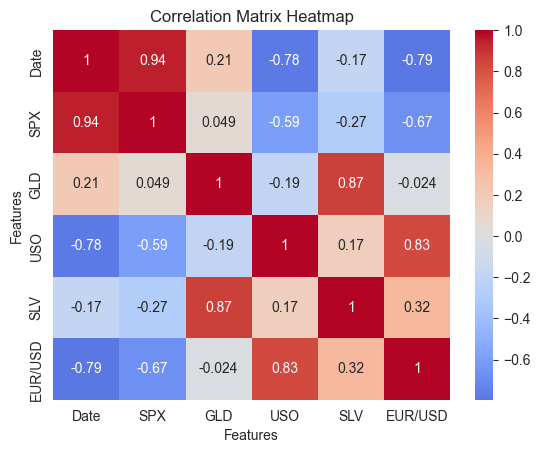

In [5]:
# Calculate correlation matrix
correlation = dataset.corr()

# Create heatmap
sns.heatmap(correlation, cmap='coolwarm',
			center=0, annot=True)

# Set title and axis labels
plt.title('Correlation Matrix Heatmap')
plt.xlabel('Features')
plt.ylabel('Features')

# Show plot
plt.show()

In [6]:
# drop SlV column
dataset.drop("SLV", axis=1,
			inplace=True)

In [7]:
# reset the index to date column
dataset.set_index("Date", inplace=True)

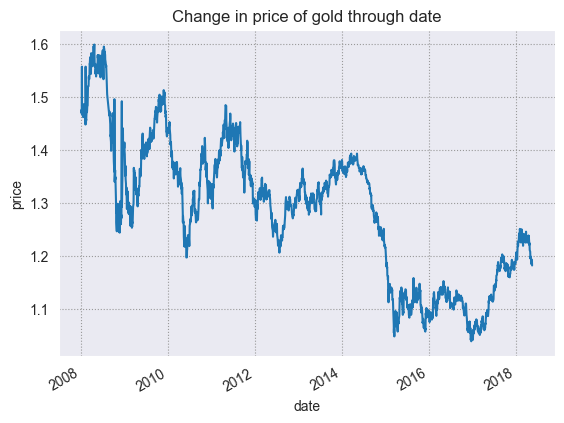

In [8]:
# plot price of gold for each increasing day
dataset["EUR/USD"].plot()
plt.title("Change in price of gold through date")
plt.xlabel("date")
plt.ylabel("price")
plt.show()

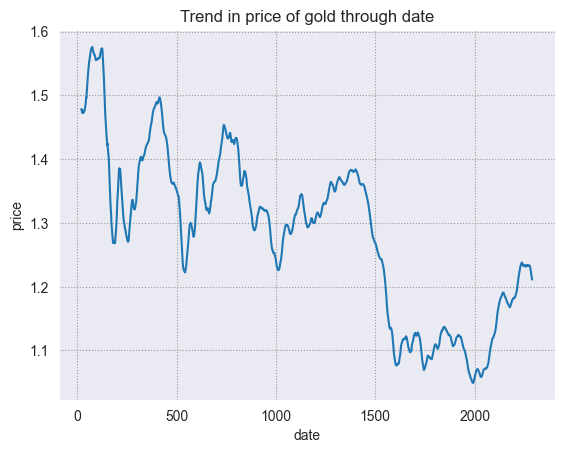

In [9]:
# apply rolling mean with window size of 3
dataset["price_trend"] = dataset["EUR/USD"]\
	.rolling(window=20).mean()

# reset the index to date column
dataset.reset_index("Date", inplace=True)

# since we have used rolling method
# for 20 rows first 2 rows will be NAN
dataset["price_trend"].loc[20:].plot()

# set title of the chart
plt.title("Trend in price of gold through date")

# set x_label of the plot
plt.xlabel("date")
plt.ylabel("price")
plt.show()

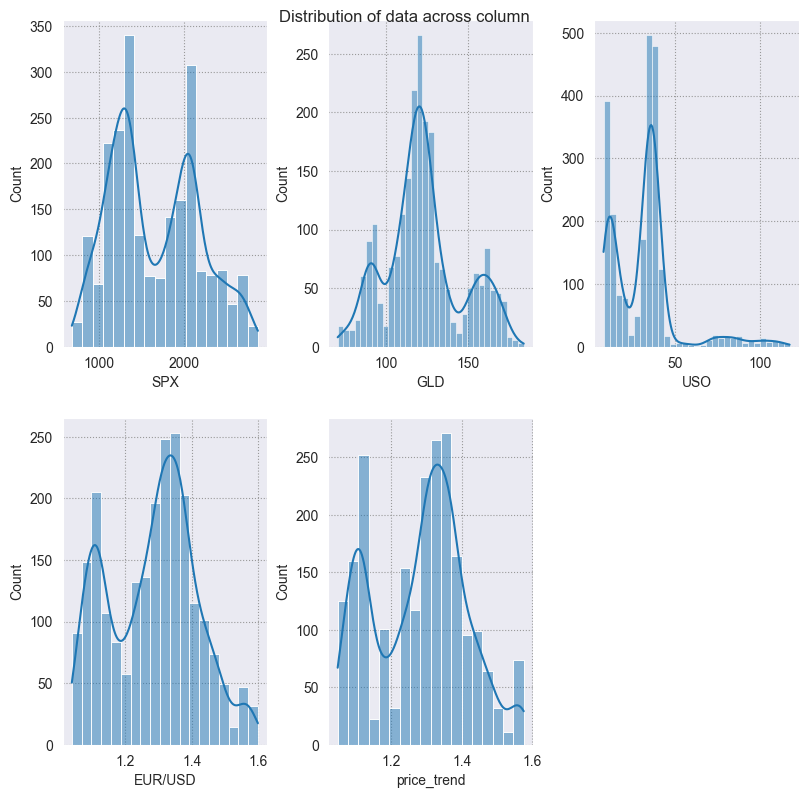

In [10]:
fig = plt.figure(figsize=(8, 8))

# suptitle of the graph
fig.suptitle('Distribution of data across column')
temp = dataset.drop("Date", axis=1).columns.tolist()
for i, item in enumerate(temp):
	plt.subplot(2, 3, i+1)
	sns.histplot(data=dataset, x=item, kde=True)
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=2.0)
plt.show()

In [12]:
# Assuming 'dataset' is your DataFrame
# Identify columns with numeric data types
numeric_columns = dataset.select_dtypes(include=['number'])

# Calculate skewness for numeric columns only
skewness = numeric_columns.skew()

# Print the skewness values
print(skewness)

SPX            0.300362
GLD            0.334138
USO            1.699331
EUR/USD       -0.005292
price_trend   -0.029588
dtype: float64


In [13]:
# apply saquare root transformation
# on the skewed dataset
dataset["USO"] = dataset["USO"]\
	.apply(lambda x: np.sqrt(x))

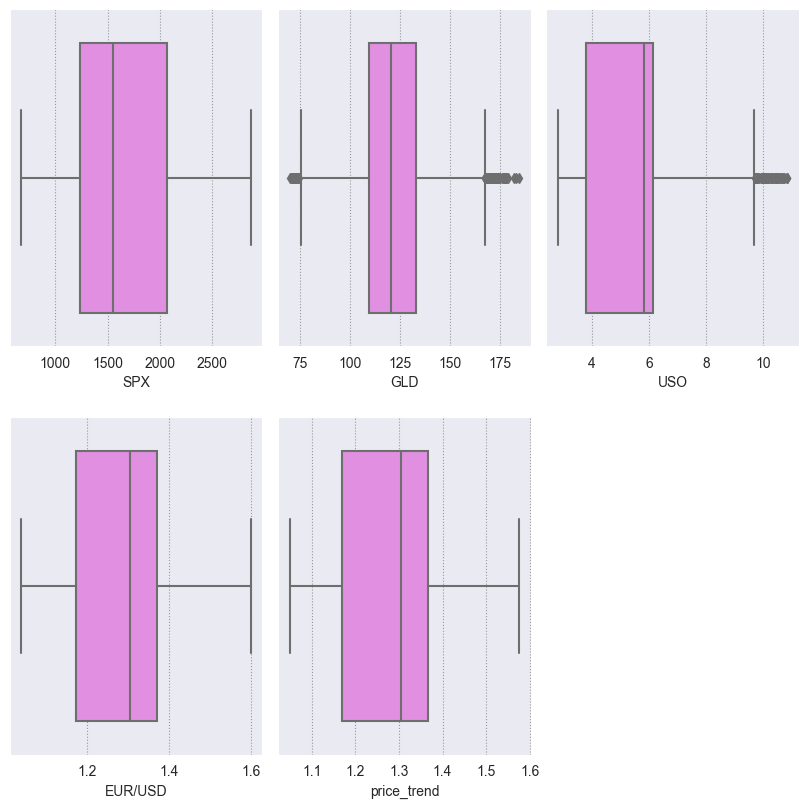

In [14]:
fig = plt.figure(figsize=(8, 8))
temp = dataset.drop("Date", axis=1).columns.tolist()
for i, item in enumerate(temp):
	plt.subplot(2, 3, i+1)
	sns.boxplot(data=dataset, x=item, color='violet')
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=2.0)
plt.show()

In [15]:
def outlier_removal(column):
	# Capping the outlier rows with Percentiles
	upper_limit = column.quantile(.95)
	# set upper limit to 95percentile
	lower_limit = column.quantile(.05)
	# set lower limit to 5 percentile
	column.loc[(column > upper_limit)] = upper_limit
	column.loc[(column < lower_limit)] = lower_limit
	return column

In [16]:
# Normalize outliers in columns except Date

dataset[['SPX', 'GLD', 'USO', 'EUR/USD']] = \
	dataset[['SPX', 'GLD', 'USO', 'EUR/USD']].apply(outlier_removal)

In [17]:
# select the features and target variable
X = dataset.drop(['Date', 'EUR/USD'], axis=1)

y = dataset['EUR/USD']
# dividing dataset in to train test
x_train, x_test,\
	y_train, y_test = train_test_split(X, y,
									test_size=0.2)

In [18]:
# Create an instance of the StandardScaler
scaler = StandardScaler()

# Fit the StandardScaler on the training dataset
scaler.fit(x_train)

# Transform the training dataset
# using the StandardScaler
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [22]:
from sklearn.impute import SimpleImputer

# Create a SimpleImputer instance
imputer = SimpleImputer(strategy='mean')  # or any other strategy you prefer

# Impute missing values in the x_train_scaled array
x_train_imputed = imputer.fit_transform(x_train_scaled)

# Find indices of missing values in x_train_scaled
missing_indices = np.isnan(x_train_scaled).any(axis=1)

# Use the non-missing rows for both x_train and y_train
x_train_without_missing = x_train_scaled[~missing_indices]
y_train_without_missing = y_train[~missing_indices]


In [24]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Lasso
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score

# Create a PolynomialFeatures object of degree 2
poly = PolynomialFeatures(degree=2)

# Create a Lasso object
lasso = Lasso()

# Define a dictionary of parameter values to search over
param_grid = {'lasso__alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1, 5, 10, 20, 30, 40]}

# Create a pipeline that first applies polynomial features and then applies Lasso regression
pipeline = make_pipeline(poly, lasso)

# Create a GridSearchCV object with the pipeline and parameter grid
lasso_grid_search = GridSearchCV(pipeline, param_grid, scoring='r2', cv=3)

# Fit the GridSearchCV object to the training data with imputed values
lasso_grid_search.fit(x_train_imputed, y_train)

# Predict the target variable using the fitted model and the test data
y_pred = lasso_grid_search.predict(x_train_imputed)

# Compute the R-squared of the fitted model on the train data
r2 = r2_score(y_train, y_pred)

# Print the R-squared
print("R-squared: ", r2)

# Print the best parameter values and score
print('Best parameter values: ', lasso_grid_search.best_params_)
print('Best score: ', lasso_grid_search.best_score_)

R-squared:  0.9660989483695006
Best parameter values:  {'lasso__alpha': 0.0001}
Best score:  0.9649513629305614


In [26]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer

# Create an imputer to handle missing values
imputer = SimpleImputer(strategy='mean')

# Fit and transform the imputer on your data
x_train_imputed = imputer.fit_transform(x_train_scaled)

# Define the parameter grid for which to search
param_grid = {'n_estimators': [50, 80, 100],
              'max_depth': [3, 5, 7]}

# Create an instance of the RandomForestRegressor
rf = RandomForestRegressor()

# Define a GridSearchCV object with RandomForestRegressor, parameter grid, scoring, and cross-validation
rf_grid_search = GridSearchCV(rf, param_grid, scoring='r2', cv=2)

# Fit the GridSearchCV object to the training data with imputed values
rf_grid_search.fit(x_train_imputed, y_train)

# Print the best parameter values and score
print('Best parameter values: ', rf_grid_search.best_params_)
print('Best score: ', rf_grid_search.best_score_)

Best parameter values:  {'max_depth': 7, 'n_estimators': 100}
Best score:  0.9764127822352957


In [28]:
from sklearn.metrics import r2_score

# Assuming you have already imported the necessary libraries and defined the rf_grid_search object

# Preprocess the test data to handle missing values
x_test_imputed = imputer.transform(x_test_scaled)  # Using the same imputer instance as before

# Compute the R-squared of the fitted model on the test data
r2 = r2_score(y_test, rf_grid_search.predict(x_test_imputed))

# Print the R-squared
print("R-squared:", r2)

R-squared: 0.979926079833231


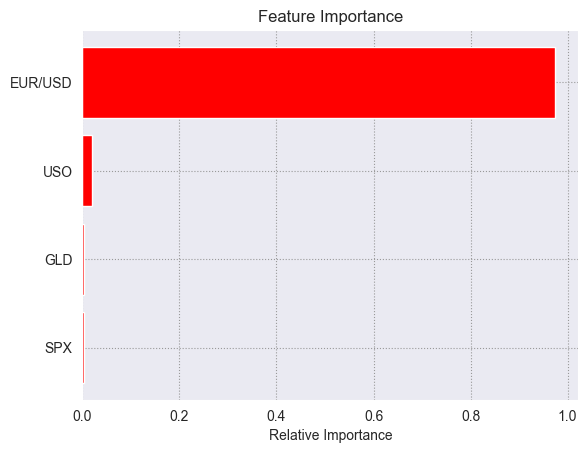

In [29]:
features = dataset.drop("Date", axis=1).columns

# store the importance of the feature
importances = rf_grid_search.best_estimator_.\
	feature_importances_


indices = np.argsort(importances)

# title of the graph
plt.title('Feature Importance')

plt.barh(range(len(indices)),
		importances[indices],
		color='red',
		align='center')

# plot bar chart
plt.yticks(range(len(indices)),
		[features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [30]:
# Create an instance of the XGBRegressor model
model_xgb = XGBRegressor()

# Fit the model to the training data
model_xgb.fit(x_train_scaled, y_train)

# Print the R-squared score on the training data
print("Xgboost Accuracy =", r2_score(
	y_train, model_xgb.predict(x_train_scaled)))

Xgboost Accuracy = 0.999370139191409


In [31]:
# Print the R-squared score on the test data
print("Xgboost Accuracy on test data =",
	r2_score(y_test,
			model_xgb.predict(x_test_scaled)))

Xgboost Accuracy on test data = 0.9878998646044862


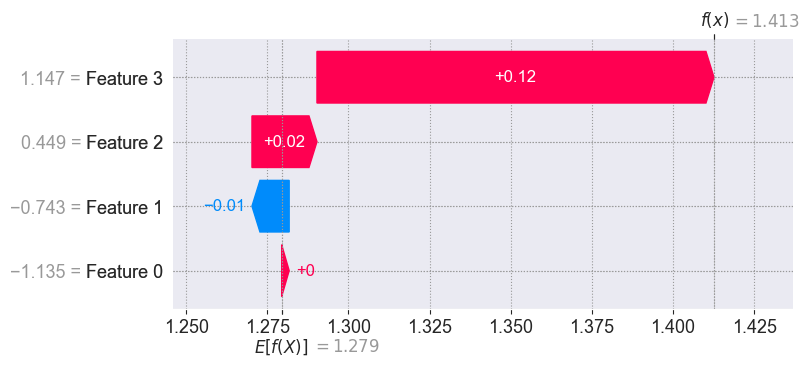

In [42]:
import shap


# Reshape the single prediction into a 2-dimensional matrix
single_prediction = x_test_scaled[0].reshape(1, -1)

# Create the SHAP explainer
explainer = shap.Explainer(model_xgb)

# Explain the single prediction
shap_values = explainer(single_prediction)

# Plot the SHAP values for the prediction
shap.plots.waterfall(shap_values[0])  # shap_values is a list, so access the first element


['SPX', 'GLD', 'USO', 'price_trend']


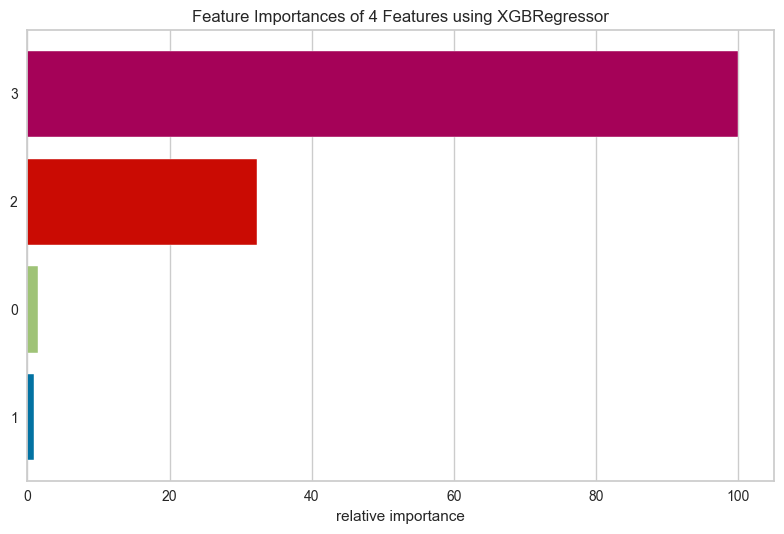

<AxesSubplot:title={'center':'Feature Importances of 4 Features using XGBRegressor'}, xlabel='relative importance'>

In [49]:
from yellowbrick.model_selection import FeatureImportances

# Define the feature names
feature_names = x_train.columns.tolist()
print(feature_names)

# Create a FeatureImportances visualizer
visualizer = FeatureImportances(model_xgb, feature_names='GLD')

# Fit the visualizer to the training data
visualizer.fit(x_train_scaled, y_train)

# Visualize the feature importances
visualizer.show()


In [51]:
# dump model using pickle library
import pickle

# dump model in file model.pkl
pickle.dump(model_xgb, open('model.pkl', 'wb'))
